# Part 4: Predictive Insight Generation
## Customer Feedback Analysis and Forecasting


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')


In [9]:
df = pd.read_csv('cleaned_customer_feedback.csv')
df['Date_Parsed'] = pd.to_datetime(df['Date_Parsed'])
print(f"Dataset loaded: {df.shape}")
df.head()


Dataset loaded: (259, 18)


,Review Title,Customer name,Rating,Rating_Numeric,Date,Date_Parsed,Category,Comments,Useful,Helpful_Count,Review_Title_Clean,Comments_Clean,Combined_Text,Review_Title_Processed,Comments_Processed,Combined_Text_Processed,Text_Length,Word_Count
0,Another Midrange killer Smartphone by Xiaomi,Rishikumar Thakur,4.0 out of 5 stars,4.0,on 1 October 2018,2018-10-01,Display,Another Midrange killer Smartphone by Xiaomi\n...,,0,Another Midrange killer Smartphone by Xiaomi,Another Midrange killer Smartphone by Xiaomi M...,Another Midrange killer Smartphone by Xiaomi A...,another midrange killer smartphone xiaomi,another midrange killer smartphone xiaomi majo...,another midrange killer smartphone xiaomi anot...,4579,860
1,vry small size mobile,Raza ji,3.0 out of 5 stars,3.0,on 15 September 2018,2018-09-15,Others,All ok but vry small size mobile,7 people found this helpful,7,vry small size mobile,All ok but vry small size mobile,vry small size mobile All ok but vry small siz...,vry small size mobile,vry small size mobile,vry small size mobile vry small size mobile,54,11
2,Full display not working in all application.,Vaibhav Patel,3.0 out of 5 stars,3.0,on 18 September 2018,2018-09-18,Others,Quite good,7 people found this helpful,7,Full display not working in all application.,Quite good,Full display not working in all application. Q...,full display working application,quite good,full display working application quite good,55,9
3,Value for Money,Amazon Customer,5.0 out of 5 stars,5.0,on 28 September 2018,2018-09-28,Display,Redmi has always have been the the king of bud...,2 people found this helpful,2,Value for Money,Redmi has always have been the the king of bud...,Value for Money Redmi has always have been the...,value money,redmi always king budget segment.and yet anoth...,value money redmi always king budget segment.a...,857,154
4,Not worth for the money,Sudhakaran Wadakkancheri,2.0 out of 5 stars,2.0,on 18 September 2018,2018-09-18,Others,worst product from MI. I am a hardcore fan of ...,6 people found this helpful,6,Not worth for the money,worst product from MI. I am a hardcore fan of ...,Not worth for the money worst product from MI....,worth money,worst product hardcore fan one really disappoi...,worth money worst product hardcore fan one rea...,108,21


## 1. Identify Recurring Issues and Complaints


In [10]:
def create_sentiment_label(rating):
    if rating >= 4.0:
        return 'Positive'
    elif rating >= 3.0:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Rating_Numeric'].apply(create_sentiment_label)
negative_reviews = df[df['Sentiment'] == 'Negative']['Comments_Processed'].dropna()
print(f"Analyzing {len(negative_reviews)} negative reviews for recurring issues")


Analyzing 46 negative reviews for recurring issues


In [11]:
negative_reviews_list = negative_reviews.astype(str).tolist()

vectorizer = CountVectorizer(max_features=50, ngram_range=(1, 3), min_df=1)
word_counts = vectorizer.fit_transform(negative_reviews_list)
feature_names = vectorizer.get_feature_names_out()
word_freq = dict(zip(feature_names, word_counts.toarray().sum(axis=0)))
top_issues = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]

print("\n" + "=" * 60)
print("TOP RECURRING ISSUES IN CUSTOMER FEEDBACK")
print("=" * 60)
for issue, count in top_issues:
    print(f"{issue:30s} : {count:3d} occurrences")
print("=" * 60)



TOP RECURRING ISSUES IN CUSTOMER FEEDBACK
phone                          :  42 occurrences
camera                         :  27 occurrences
quality                        :  23 occurrences
please                         :  20 occurrences
buy                            :  16 occurrences
good                           :  15 occurrences
amazon                         :  14 occurrences
front                          :  13 occurrences
mobile                         :  13 occurrences
screen                         :  13 occurrences
issue                          :  12 occurrences
worst                          :  12 occurrences
problem                        :  10 occurrences
product                        :  10 occurrences
poor                           :   9 occurrences


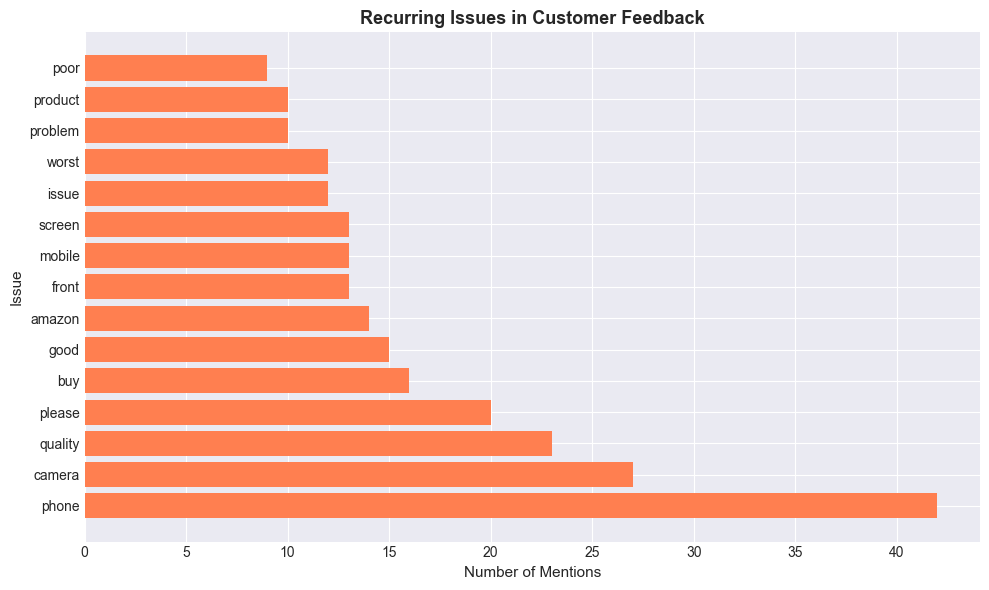

Visualization saved


In [12]:
issues_df = pd.DataFrame(top_issues, columns=['Issue', 'Count'])

plt.figure(figsize=(10, 6))
plt.barh(issues_df['Issue'], issues_df['Count'], color='coral')
plt.xlabel('Number of Mentions', fontsize=11)
plt.ylabel('Issue', fontsize=11)
plt.title('Recurring Issues in Customer Feedback', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('recurring_issues_chart.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualization saved")


## 2. Customer Satisfaction Score Prediction


In [13]:
df_time = df[df['Date_Parsed'].notna()].copy()
df_time['YearMonth'] = df_time['Date_Parsed'].dt.to_period('M')

monthly_stats = df_time.groupby('YearMonth').agg({
    'Rating_Numeric': ['mean', 'count']
}).reset_index()

monthly_stats.columns = ['YearMonth', 'Avg_Rating', 'Review_Count']
monthly_stats['YearMonth_str'] = monthly_stats['YearMonth'].astype(str)

print("Monthly Satisfaction Trends:")
print(monthly_stats)


Monthly Satisfaction Trends:
  YearMonth  Avg_Rating  Review_Count YearMonth_str
0   2018-09    3.937238           239       2018-09
1   2018-10    3.900000            20       2018-10


In [14]:
monthly_stats['Month_Index'] = range(len(monthly_stats))

X = monthly_stats[['Month_Index']]
y = monthly_stats['Avg_Rating']

model = LinearRegression()
model.fit(X, y)

next_month_index = len(monthly_stats)
next_month_prediction = model.predict([[next_month_index]])[0]

print("\n" + "=" * 60)
print("CUSTOMER SATISFACTION FORECAST")
print("=" * 60)
print(f"Current Average Rating: {monthly_stats['Avg_Rating'].iloc[-1]:.2f}")
print(f"Predicted Next Month Rating: {next_month_prediction:.2f}")
print(f"Trend: {'Improving' if next_month_prediction > monthly_stats['Avg_Rating'].iloc[-1] else 'Declining'}")
print("=" * 60)



CUSTOMER SATISFACTION FORECAST
Current Average Rating: 3.90
Predicted Next Month Rating: 3.86
Trend: Declining


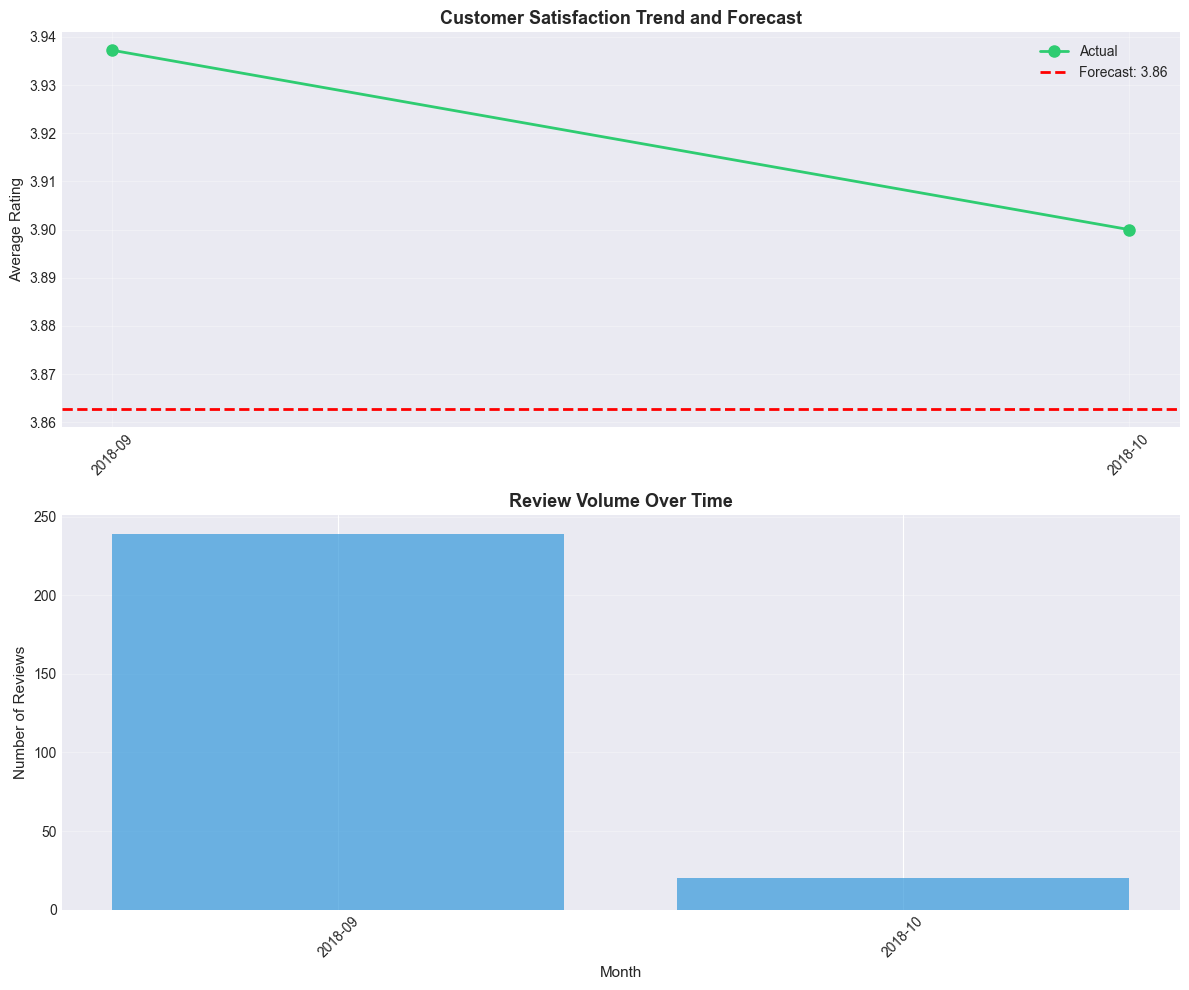

Visualization saved


In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].plot(monthly_stats['YearMonth_str'], monthly_stats['Avg_Rating'], 
             marker='o', linewidth=2, markersize=8, color='#2ecc71', label='Actual')
axes[0].axhline(y=next_month_prediction, color='red', linestyle='--', 
                linewidth=2, label=f'Forecast: {next_month_prediction:.2f}')
axes[0].set_title('Customer Satisfaction Trend and Forecast', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Average Rating', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(monthly_stats['YearMonth_str'], monthly_stats['Review_Count'], 
            color='#3498db', alpha=0.7)
axes[1].set_title('Review Volume Over Time', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Number of Reviews', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('satisfaction_forecast_chart.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualization saved")


## 3. Generate PDF Report


In [16]:
pdf_filename = 'AI_insights_report.pdf'

with PdfPages(pdf_filename) as pdf:
    fig = plt.figure(figsize=(11, 8.5))
    fig.text(0.5, 0.95, 'AI INSIGHTS REPORT', ha='center', fontsize=20, fontweight='bold')
    fig.text(0.5, 0.90, 'Customer Feedback Analysis', ha='center', fontsize=14)
    fig.text(0.5, 0.85, f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M")}', 
             ha='center', fontsize=10)
    
    report_text = f"""
EXECUTIVE SUMMARY
{'='*70}

Total Reviews Analyzed: {len(df)}
Analysis Period: {df['Date_Parsed'].min().strftime('%Y-%m')} to {df['Date_Parsed'].max().strftime('%Y-%m')}
Average Satisfaction Score: {df['Rating_Numeric'].mean():.2f}/5.0

SENTIMENT DISTRIBUTION
{'='*70}
Positive Reviews: {(df['Sentiment'] == 'Positive').sum()} ({(df['Sentiment'] == 'Positive').sum()/len(df)*100:.1f}%)
Neutral Reviews: {(df['Sentiment'] == 'Neutral').sum()} ({(df['Sentiment'] == 'Neutral').sum()/len(df)*100:.1f}%)
Negative Reviews: {(df['Sentiment'] == 'Negative').sum()} ({(df['Sentiment'] == 'Negative').sum()/len(df)*100:.1f}%)

TOP RECURRING ISSUES
{'='*70}
"""
    
    for i, (issue, count) in enumerate(top_issues[:10], 1):
        report_text += f"{i}. {issue}: {count} mentions\\n"
    
    report_text += f"""

CUSTOMER SATISFACTION FORECAST
{'='*70}
Current Rating: {monthly_stats['Avg_Rating'].iloc[-1]:.2f}
Forecasted Next Month: {next_month_prediction:.2f}
Trend: {'Improving' if next_month_prediction > monthly_stats['Avg_Rating'].iloc[-1] else 'Declining'}

RECOMMENDATIONS
{'='*70}
1. Address top recurring issue: {top_issues[0][0]}
2. Monitor satisfaction trends closely
3. Focus on reducing negative sentiment
4. Implement feedback-driven improvements
"""
    
    fig.text(0.1, 0.75, report_text, ha='left', va='top', fontsize=9, 
             family='monospace', verticalalignment='top')
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    fig = plt.figure(figsize=(11, 8.5))
    ax = fig.add_subplot(111)
    img = plt.imread('recurring_issues_chart.png')
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Recurring Issues Visualization', fontsize=14, fontweight='bold', pad=20)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    fig = plt.figure(figsize=(11, 8.5))
    ax = fig.add_subplot(111)
    img = plt.imread('satisfaction_forecast_chart.png')
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Satisfaction Forecast Visualization', fontsize=14, fontweight='bold', pad=20)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"\nPDF Report generated: {pdf_filename}")
print("\n" + "=" * 60)
print("PART 4 COMPLETED")
print("=" * 60)
print("Deliverables:")
print("1. Recurring issues identified")
print("2. Satisfaction forecast generated")
print("3. Visualizations created")
print("4. AI_insights_report.pdf")
print("=" * 60)



PDF Report generated: AI_insights_report.pdf

PART 4 COMPLETED
Deliverables:
1. Recurring issues identified
2. Satisfaction forecast generated
3. Visualizations created
4. AI_insights_report.pdf
